(s:gp_krr_code)=
# Explore GPs and KRR with code

## Functions and helpers

In [1]:
import itertools
import multiprocessing as mp

##import multiprocess as mp

import numpy as np
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from matplotlib import cm, ticker, colors

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge

from icecream import ic


def gt_func(x):
    """Ground truth"""
    return np.sin(x) * np.exp(-0.1 * x) + 10


def gaussian_noise(x, rng, sigma=0.1):
    """Constant Gaussian noise."""
    return rng.normal(loc=0, scale=sigma, size=x.shape[0])


def transform_1d(scaler, x):
    assert x.ndim == 1
    return scaler.transform(x.reshape(-1, 1))[:, 0]


def de_callback(xk, convergence=None):
    """Callback for differential_evolution that prints the best individual per
    iteration."""
    ##ic(xk)


def de_callback_logscale(xk, convergence=None):
    """Callback for differential_evolution that prints the best individual per
    iteration.

    Since GaussianProcessRegressor's hyper optimizer code path internally works
    with log(p) (= xk[0]) and log(r) (= xk[1]), we need to exp() them before
    printing.

    We also do that in HyperOpt if logscale=True.
    """
    ##ic(np.exp(xk))


def gp_optimizer(obj_func, initial_theta, bounds):
    """Custom optimizer for GaussianProcessRegressor using
    differential_evolution.

    Ignore initial_theta since we need only bounds for differential_evolution.
    """
    # Avoid pickle error when using multiprocessing in
    # differential_evolution(..., workers=-1). We'd use
    # https://github.com/uqfoundation/multiprocess instead of the stdlib's
    # multiprocessing to work around that but sadly differential_evolution()
    # uses the latter internally, so we're stuck with that.
    global _gp_obj_func_wrapper

    def _gp_obj_func_wrapper(params):
        ##print(f"{obj_func(initial_theta)=}")
        # obj_func(theta, eval_gradient=True) hard-coded in
        # GaussianProcessRegressor, so it always returns the function value and
        # grad. However, we only need the function's value in
        # differential_evolution() below. obj_func = -log_marginal_likelihood.
        ##val, grad = obj_func(params)
        return obj_func(params)[0]

    opt_result = differential_evolution(
        ##lambda params: obj_func(params)[0],  # nope, no pickle for you
        _gp_obj_func_wrapper,
        bounds=bounds,
        callback=de_callback_logscale,
        **de_kwds_common,
    )
    return opt_result.x, opt_result.fun


##from sklearn.model_selection import cross_val_score
def simple_cv(model, X, y, cv):
    """Same as

        -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error")

    but much faster because we bypass the rich API of
    cross_val_score and can thus skip many many checks.

    Note that the double negative in -cross_val_score() and "neg_" is needed
    b/c of the sklearn API:

    "All scorer objects follow the convention that higher return values are
    better than lower return values. Thus metrics which measure the distance
    between the model and the data, like metrics.mean_squared_error, are
    available as neg_mean_squared_error which return the negated value of the
    metric."

    See https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    """
    errs = np.empty((cv.get_n_splits(X),), dtype=float)
    for ii, tup in enumerate(cv.split(X)):
        idxs_train, idxs_test = tup
        fm = model.fit(X[idxs_train, ...], y[idxs_train, ...])
        d = fm.predict(X[idxs_test, ...]) - y[idxs_test, ...]
        # MSE
        errs[ii] = np.dot(d, d) / len(d)
    return errs
    ##return -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error")


class HyperOpt:
    """Optimize hyper params of a sklearn model using
    differential_evolution."""

    def __init__(self, bounds, get_model, logscale=False):
        self.bounds = bounds
        self.get_model = get_model
        self.logscale = logscale

    def obj_func(self, params, X, y):
        raise NotImplementedError

    def fit(self, X, y, return_params=False):
        global _ho_obj_func_wrapper

        if self.logscale:
            bounds_transform = lambda x: np.log(x)
            params_transform = lambda x: np.exp(x)
            callback = de_callback_logscale
        else:
            bounds_transform = lambda x: x
            params_transform = lambda x: x
            callback = de_callback

        def _ho_obj_func_wrapper(params):
            return self.obj_func(params_transform(params), X, y)

        opt_result = differential_evolution(
            _ho_obj_func_wrapper,
            bounds=bounds_transform(bounds),
            callback=callback,
            **de_kwds_common,
        )
        params = params_transform(opt_result.x)
        f = self.get_model(params).fit(X, y)
        if return_params:
            return f, params
        else:
            return f


class HyperOptKRR(HyperOpt):
    def __init__(self, *args, seed=None, **kwds):
        super().__init__(*args, **kwds)
        self.seed = seed

    def obj_func(self, params, X, y):
        cv = KFold(n_splits=5, random_state=self.seed, shuffle=True)
        return simple_cv(self.get_model(params), X, y, cv=cv).mean()


class HyperOptGP(HyperOpt):
    def obj_func(self, params, X, y):
        return -self.get_model(params).fit(X, y).log_marginal_likelihood()

## Data

In [2]:
seed = 123
rng = np.random.default_rng(seed=seed)

# Equidistant x points: constant y_std (from GP) in-distribution
##x = np.linspace(0, 30, 60)
#
# Random x points for varying y_std. Also create a gap in the middle to
# show high y_std.
x1 = np.sort(rng.uniform(0, 12, 20), axis=0)
x2 = np.sort(rng.uniform(20, 32, 20), axis=0)
x = np.concatenate((x1, x2))
xspan = x.max() - x.min()
xi = np.linspace(x.min() - 0.3 * xspan, x.max() + 0.3 * xspan, len(x) * 10)
y = gt_func(x) + gaussian_noise(x, rng, sigma=0.075)
yi_gt = gt_func(xi)

# Data scaling.
in_scaler = StandardScaler().fit(x.reshape(-1, 1))
out_scaler = StandardScaler().fit(y.reshape(-1, 1))
x = transform_1d(in_scaler, x)
xi = transform_1d(in_scaler, xi)
y = transform_1d(out_scaler, y)
yi_gt = transform_1d(out_scaler, yi_gt)
X = x[:, None]
XI = xi[:, None]

## Correctness checks and examples on how to play with optimizers

This is actually the interesting part. Please inspect the code.

In [3]:
# -------------------------------------------------------------------------
# Sanity check KernelRidge API: alpha added to diag of kernel matrix.
# -------------------------------------------------------------------------
length_scale = 1
noise_level = 0.1
kp = RBF(length_scale=length_scale)
f_krr_1 = KernelRidge(alpha=noise_level, kernel=kp).fit(X, y)
f_krr_2 = KernelRidge(alpha=0, kernel="precomputed").fit(
    kp(X, X) + np.eye(X.shape[0]) * noise_level, y
)

np.testing.assert_allclose(f_krr_1.dual_coef_, f_krr_2.dual_coef_)
np.testing.assert_allclose(f_krr_1.predict(XI), f_krr_2.predict(kp(XI, X)))

# -------------------------------------------------------------------------
# Show that WhiteKernel(noise_level=) is equal to regularization param
# alpha=noise_level in both sklearn models. No hyperopt just yet
# (GaussianProcessRegressor(optimizer=None)). Use fixed hyper
# params=[length_scale,noise_level].
# -------------------------------------------------------------------------
f_gp_kp = GaussianProcessRegressor(
    kernel=kp,
    optimizer=None,
    normalize_y=False,
    alpha=noise_level,
).fit(X, y)

f_gp_kpr = GaussianProcessRegressor(
    kernel=RBF(length_scale=length_scale)
    + WhiteKernel(noise_level=noise_level),
    optimizer=None,
    normalize_y=False,
    alpha=0,
).fit(X, y)

np.testing.assert_allclose(f_gp_kp.alpha_, f_gp_kpr.alpha_)
np.testing.assert_allclose(f_gp_kp.predict(XI), f_gp_kpr.predict(XI))

np.testing.assert_allclose(f_gp_kp.alpha_, f_krr_1.dual_coef_)
np.testing.assert_allclose(f_gp_kp.predict(XI), f_krr_1.predict(XI))

# -------------------------------------------------------------------------
# Non-zero mean for fixed length_scale and noise_level.
# -------------------------------------------------------------------------
f_krr_nzm = KernelRidge(alpha=noise_level, kernel=kp).fit(X, y + 1000)
f_gp_nzm = GaussianProcessRegressor(
    kernel=RBF(length_scale=length_scale)
    + WhiteKernel(noise_level=noise_level),
    optimizer=None,
    normalize_y=False,
    alpha=0,
).fit(X, y + 1000)

np.testing.assert_allclose(f_gp_nzm.alpha_, f_krr_nzm.dual_coef_)
np.testing.assert_allclose(f_gp_nzm.predict(XI), f_krr_nzm.predict(XI))

# -------------------------------------------------------------------------
# hyperopt gp
#
# Show 4 ways to opt [length_scale, noise_level]. One using the default
# optimizer for reference. Then 3 ways to use the custom differential
# evolution (DE) based one using the HyperOpt helper class.
#
# DE results must be exactly equal if we use logscale=True, i.e. what
# GaussianProcessRegressor does internally, so these tests only check
# different code paths doing the same operations (of course also we fix all
# RNG seeds, so DE is reproducible).
#
# With logscale=False params are not equal but very close, also because we
# use polish=True which adds a final local optimizer run starting from the
# best DE result where we assume that we're close to the global opt and
# things are convex-ish.
# -------------------------------------------------------------------------
length_scale_bounds = (1e-5, 10)
noise_level_bounds = (1e-10, 10)
bounds = [length_scale_bounds, noise_level_bounds]

de_kwds_common = dict(
    polish=True,
    disp=False,
    atol=0,
    tol=0.001,
    popsize=20,
    maxiter=10000,
    workers=-1,
    updating="deferred",
    seed=seed,
)

# Internal optimizer API. Use default local optimizer (BFGS).
#
# For the wider bounds above the -LML shows big flat plateaus and so the
# local optimizer always goes off into the wild blue yonder with
# n_restarts_optimizer=0 (the default).
#
##ic("opt gp internal default RBF + WhiteKernel ...")
f_gp_0 = GaussianProcessRegressor(
    kernel=RBF(length_scale_bounds=length_scale_bounds)
    + WhiteKernel(
        noise_level_bounds=noise_level_bounds,
    ),
    n_restarts_optimizer=5,
    normalize_y=False,
    alpha=0,
).fit(X, y)
params_gp_0 = np.array(
    [
        f_gp_0.kernel_.k1.length_scale,
        f_gp_0.kernel_.k2.noise_level,
    ]
)
ic(params_gp_0)

# Internal optimizer API. Use differential_evolution.
#
##ic("opt gp internal RBF + WhiteKernel ...")
f_gp_1 = GaussianProcessRegressor(
    kernel=RBF(length_scale_bounds=length_scale_bounds)
    + WhiteKernel(
        noise_level_bounds=noise_level_bounds,
    ),
    n_restarts_optimizer=0,
    optimizer=gp_optimizer,
    normalize_y=False,
    alpha=0,
).fit(X, y)

params_gp_1 = np.array(
    [
        f_gp_1.kernel_.k1.length_scale,
        f_gp_1.kernel_.k2.noise_level,
    ]
)
ic(params_gp_1)

# External optimizer using HyperOpt helper class.
#
# RBF + WhiteKernel
#
##ic("opt gp external RBF + WhiteKernel ...")
get_model_gp_2 = lambda params: GaussianProcessRegressor(
    kernel=RBF(length_scale=params[0]) + WhiteKernel(noise_level=params[1]),
    optimizer=None,
    normalize_y=False,
    alpha=0,
)
f_gp_2, params_gp_2 = HyperOptGP(
    get_model=get_model_gp_2,
    bounds=bounds,
    logscale=True,
).fit(X, y, return_params=True)
ic(params_gp_2)

# External optimizer using HyperOpt helper class.
#
# RBF, alpha
#
##ic("opt gp external RBF + alpha ...")
get_model_gp_3 = lambda params: GaussianProcessRegressor(
    kernel=RBF(length_scale=params[0]),
    optimizer=None,
    normalize_y=False,
    alpha=params[1],
)
f_gp_3, params_gp_3 = HyperOptGP(
    get_model=get_model_gp_3,
    bounds=bounds,
    logscale=True,
).fit(X, y, return_params=True)
ic(params_gp_3)

np.testing.assert_allclose(params_gp_1, params_gp_2)
np.testing.assert_allclose(params_gp_1, params_gp_3)

np.testing.assert_allclose(f_gp_1.alpha_, f_gp_2.alpha_)
np.testing.assert_allclose(f_gp_1.alpha_, f_gp_3.alpha_)

np.testing.assert_allclose(f_gp_1.predict(XI), f_gp_2.predict(XI))
np.testing.assert_allclose(f_gp_1.predict(XI), f_gp_3.predict(XI))

# External optimizer using HyperOpt helper class.
#
# RBF, alpha
# logscale=False
#
##ic("opt gp external RBF + alpha nolog ...")
get_model_gp_3_nolog = lambda params: GaussianProcessRegressor(
    kernel=RBF(length_scale=params[0]),
    optimizer=None,
    normalize_y=False,
    alpha=params[1],
)
f_gp_3_nolog, params_gp_3_nolog = HyperOptGP(
    get_model=get_model_gp_3_nolog,
    bounds=bounds,
    logscale=False,
).fit(X, y, return_params=True)
ic(params_gp_3_nolog)

# -------------------------------------------------------------------------
# hyperopt krr
#
# KRR params will be different b/c CV != log_marginal_likelihood
# -------------------------------------------------------------------------
get_model_krr = lambda params: KernelRidge(
    alpha=params[1], kernel=RBF(length_scale=params[0])
)

##ic("opt krr RBF + alpha ...")
f_krr, params_krr = HyperOptKRR(
    bounds=bounds,
    get_model=get_model_krr,
    logscale=True,
    seed=seed,
).fit(X, y, return_params=True)
ic(params_krr)

##ic("opt krr RBF + alpha nolog ...")
f_krr_nolog, params_krr_nolog = HyperOptKRR(
    bounds=bounds,
    get_model=get_model_krr,
    logscale=False,
    seed=seed,
).fit(X, y, return_params=True)
ic(params_krr_nolog)

ic

|

params_gp_0

:

array

(

[

0.11021769

,

0.05521954

]

)

ic

|

params_gp_1

:

array

(

[

0.11021771

,

0.05521953

]

)

ic

|

params_gp_2

:

array

(

[

0.11021771

,

0.05521953

]

)

ic

|

params_gp_3

:

array

(

[

0.11021771

,

0.05521953

]

)

ic

|

params_gp_3_nolog

:

array

(

[

0.11021768

,

0.05521953

]

)

ic

|

params_krr

:

array

(

[

0.15470176

,

0.01443063

]

)

ic

|

params_krr_nolog

:

array

(

[

0.15470279

,

0.01442918

]

)

array([0.15470279, 0.01442918])

## Plot GP and KRR predictions after hyperopt

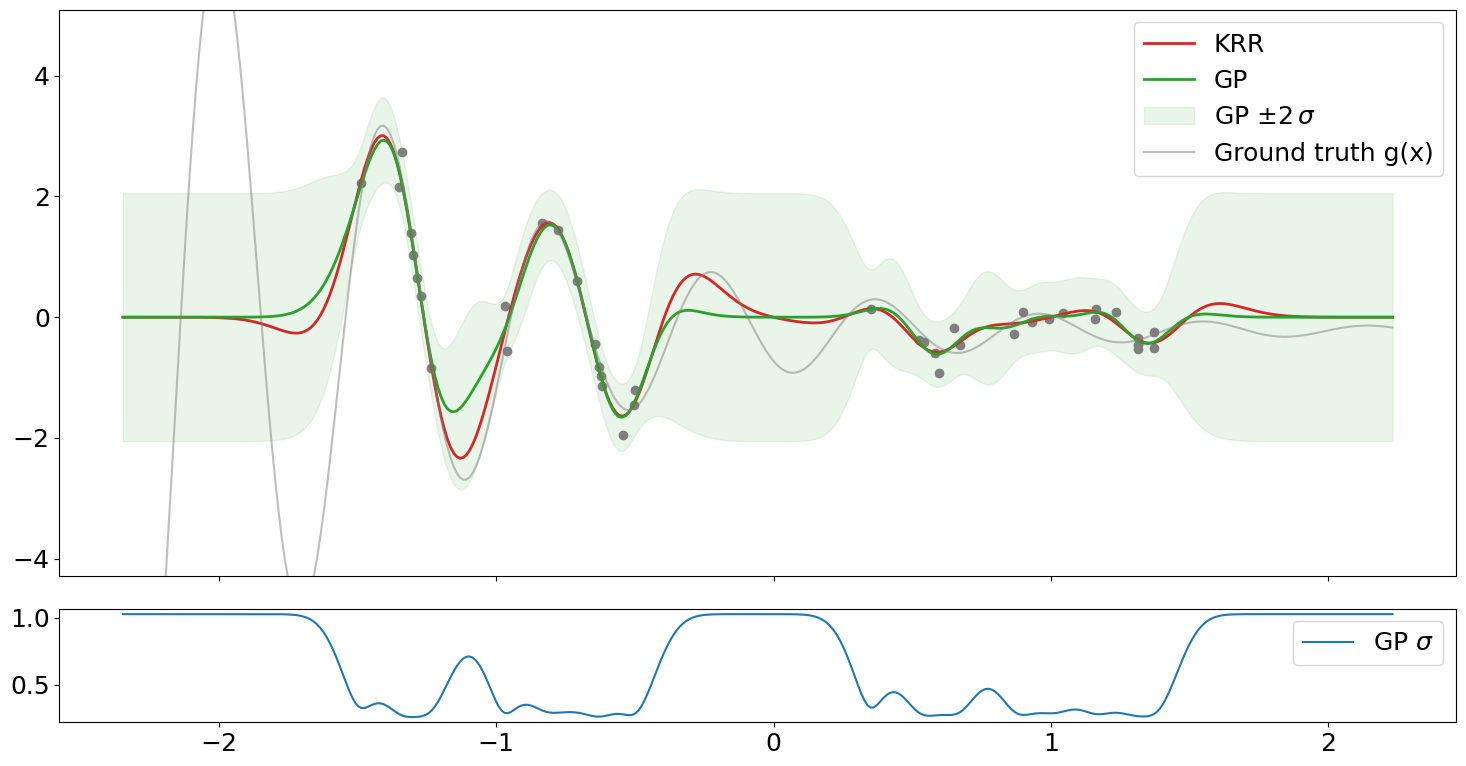

In [4]:
# -------------------------------------------------------------------------
# Plot functions, data and GP's std
# -------------------------------------------------------------------------
plt.rcParams["figure.autolayout"] = True
plt.rcParams["font.size"] = 18
savefig = False

yi_krr = f_krr.predict(XI)
yi_gp, yi_gp_std = f_gp_1.predict(XI, return_std=True)
##yi_gp, yi_gp_std = f_gp_3_nolog.predict(XI, return_std=True)

fig1, axs = plt.subplots(
    nrows=2,
    sharex=True,
    gridspec_kw=dict(height_ratios=[1, 0.2]),
    figsize=(15, 8),
)
axs[0].plot(x, y, "o", color="tab:gray")
axs[0].plot(xi, yi_krr, label="KRR", color="tab:red", lw=2)
axs[0].plot(xi, yi_gp, label="GP", color="tab:green", lw=2)
axs[0].fill_between(
    xi,
    yi_gp - 2 * yi_gp_std,
    yi_gp + 2 * yi_gp_std,
    alpha=0.1,
    color="tab:green",
    label=r"GP $\pm 2\,\sigma$",
)

yspan = y.max() - y.min()
axs[0].plot(xi, yi_gt, label="Ground truth g(x)", color="tab:gray", alpha=0.5)
axs[0].set_ylim(y.min() - 0.5 * yspan, y.max() + 0.5 * yspan)

axs[1].plot(xi, yi_gp_std, label=r"GP $\sigma$")

for ax in axs:
    ax.legend()

## Plot GP and KRR hyperparameter objective functions

So here we have it. -LML $\neq$ CV, and therefore the optimal hyperparameters
$(\ell,\eta)$ are different.

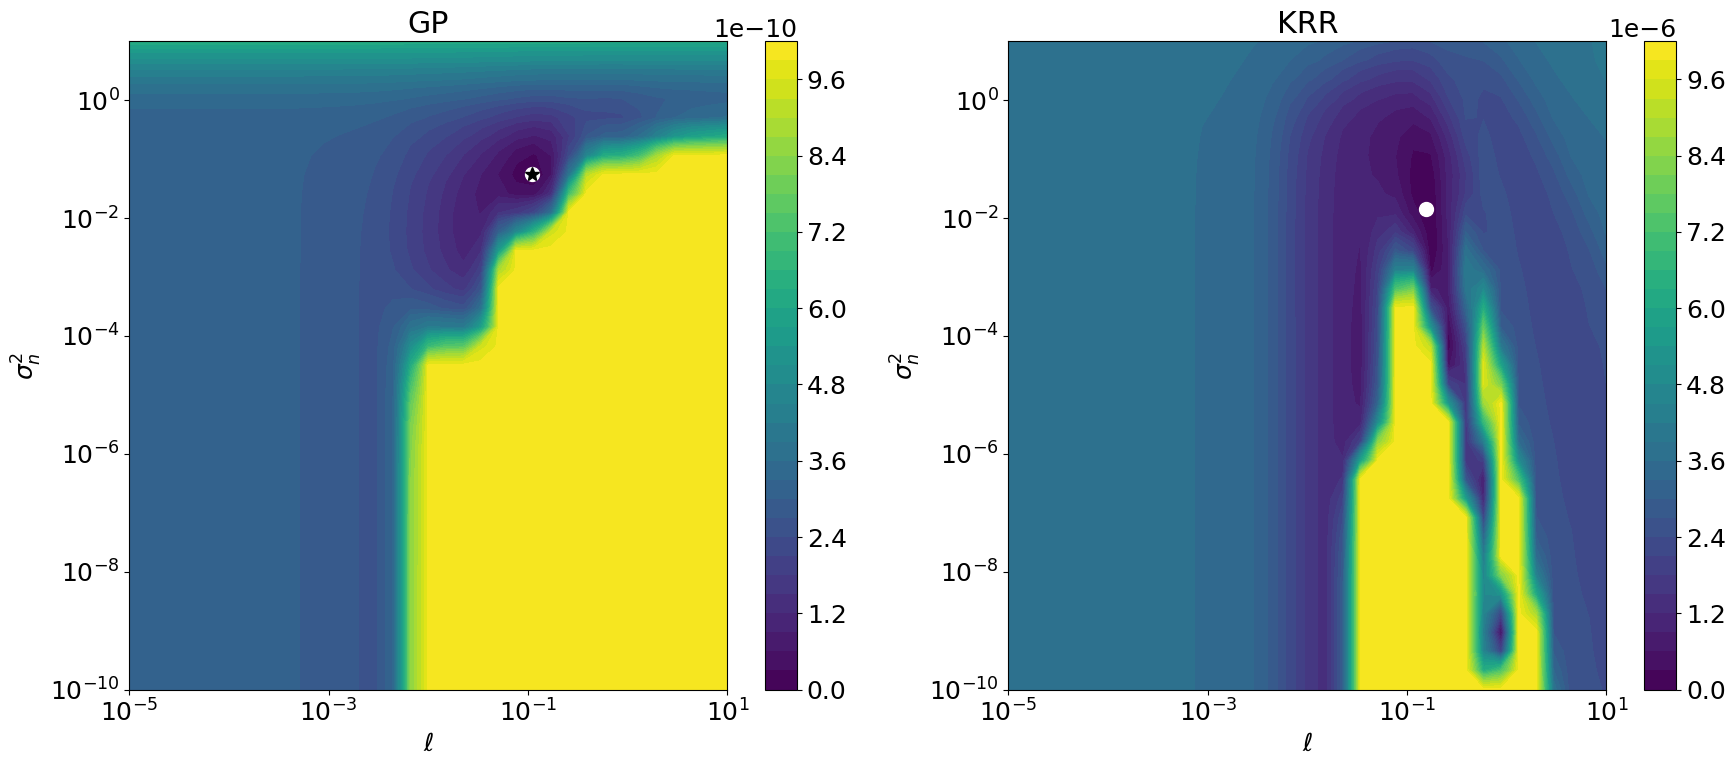

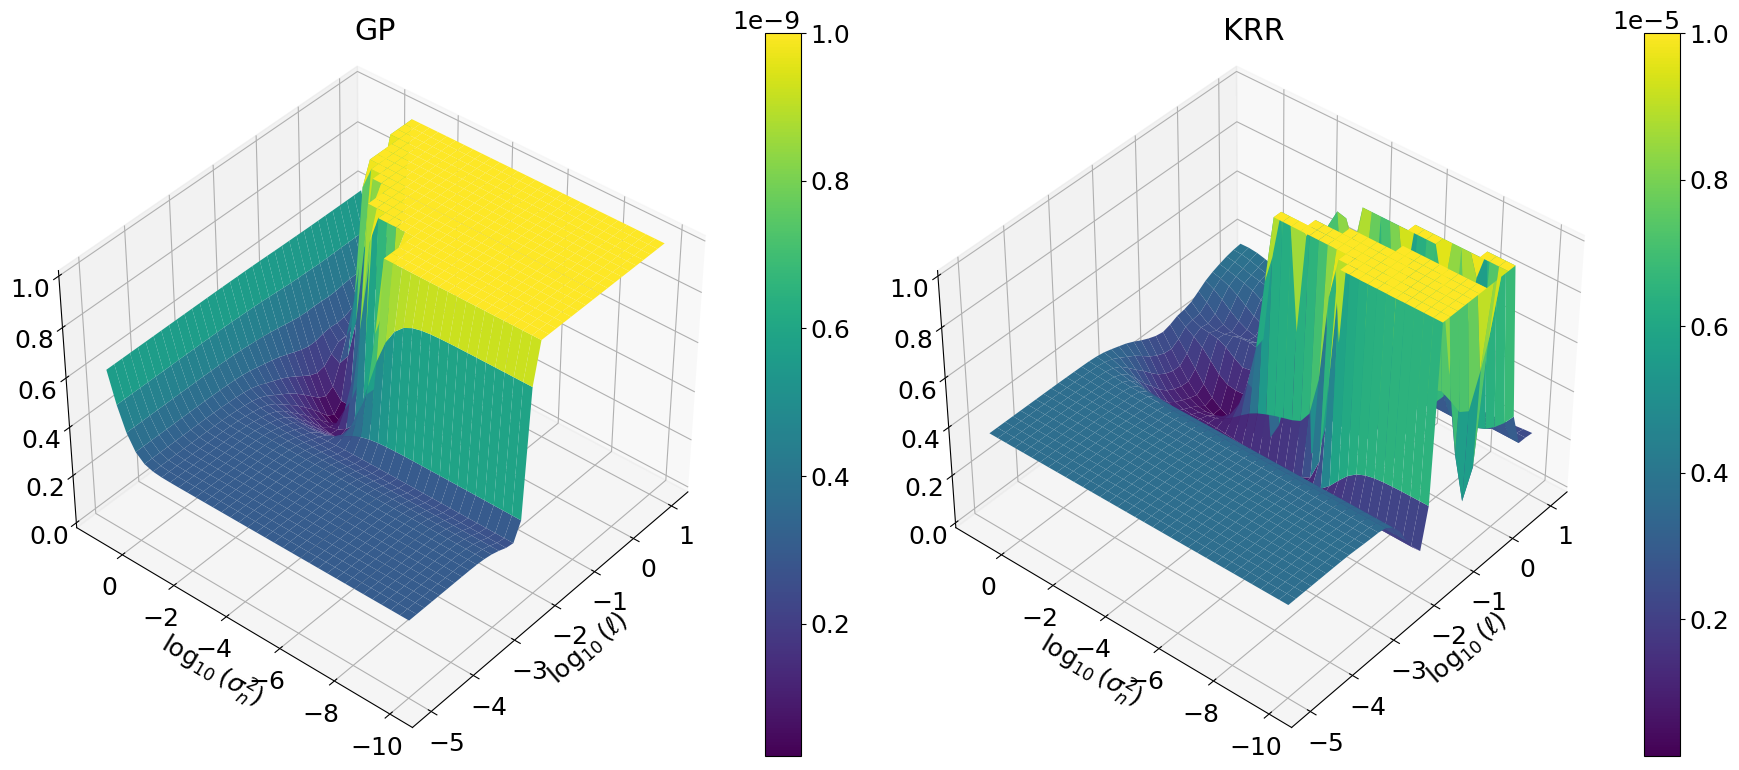

In [5]:
# Could re-use HyperOpt instances from above, but re-create here for
# clarity.
##ic("Plot hyperopt objective functions")
nsample = 35
nlevels = 35
z_log = False
length_scale = np.logspace(*np.log10(length_scale_bounds), nsample)
noise_level = np.logspace(*np.log10(noise_level_bounds), nsample)
grid = np.array(list(itertools.product(length_scale, noise_level)))
fig2, axs2d = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
fig3, axs3d = plt.subplots(
    nrows=1, ncols=2, figsize=(18, 8), subplot_kw={"projection": "3d"}
)

# zmax for linear z scale (see below)
cases = dict(gp=dict(zmax=1e-9), krr=dict(zmax=1e-5))

for icol, name in enumerate(cases):
    ax2d = axs2d[icol]
    ax3d = axs3d[icol]
    ax2d.set_title(name.upper())
    ax3d.set_title(name.upper())
    if name == "krr":
        ho = HyperOptKRR(
            bounds=bounds,
            get_model=get_model_krr,
            seed=seed,
        )

        def func(params):
            return ho.obj_func(params, X, y)

        params_opt = params_krr
    elif name == "gp":

        # Use a fitted GP object from above that has RBF+WhiteKernel such
        # that we can call log_marginal_likelihood() with a length 2 param
        # array.
        #
        def func(params):
            return -f_gp_1.log_marginal_likelihood(np.log(params))

        # Use HyperOpt API defined above.
        #
        ##ho = HyperOptGP(
        ##    get_model=get_model_gp_2,
        ##    bounds=bounds,
        ##)

        ##def func(params):
        ##    return ho.obj_func(params, X, y)

        params_opt = params_gp_1

    with mp.Pool(mp.cpu_count()) as pool:
        zz = np.array(pool.map(func, grid))

    # z log scale looks nice but is hard to interpret, also it heavily
    # depends on eps of course. When not using a z log scale we need to cut
    # off at z >= zmax to visualize low z value regions where the global
    # mins live. Note that zmax depends on bounds and thus on the range of
    # z values. Compared to krr, the GP's LML is essentially flat around
    # the min. Still DE and the local optimizer find the same min.
    if z_log:
        eps = 0.01
        zz -= zz.min() - eps
        zz /= zz.max()
    else:
        zmax = cases[name]["zmax"]
        zz -= zz.min()
        zz /= zz.max()
        ##zz = np.ma.masked_where(zz > zmax, zz)
        zz[zz >= zmax] = zmax

    _X, _Y = np.meshgrid(length_scale, noise_level, indexing="ij")
    Z = zz.reshape((_X.shape[0], _X.shape[1]))

    if z_log:
        levels = np.logspace(np.log10(zz.min()), np.log10(zz.max()), nlevels)
        pl2d = ax2d.contourf(_X, _Y, Z, levels=levels, norm=colors.LogNorm())
        pl3d = ax3d.plot_surface(
            np.log10(_X), np.log10(_Y), np.log10(Z), cmap=cm.viridis
        )
    else:
        pl2d = ax2d.contourf(_X, _Y, Z, levels=nlevels)
        pl3d = ax3d.plot_surface(
            np.log10(_X),
            np.log10(_Y),
            Z,
            cmap=cm.viridis,
        )
    ax3d.view_init(elev=40, azim=-140, roll=0)

    fig2.colorbar(pl2d, ax=ax2d)
    fig3.colorbar(pl3d, ax=ax3d)
    ax2d.plot(*params_opt, "o", ms=10, color="white")
    if name == "gp":
        ax2d.plot(*params_gp_0, "*", ms=10, color="black")
    ax2d.set_xlabel(r"$\ell$")
    ax2d.set_ylabel(r"$\sigma_n^2$")
    ax3d.set_xlabel(r"$\log_{10}(\ell)$")
    ax3d.set_ylabel(r"$\log_{10}(\sigma_n^2)$")
    ax2d.set_xscale("log")
    ax2d.set_yscale("log")

if savefig:
    fig1.savefig("gp_krr_pred.pdf")
    fig2.savefig("gp_krr_hyperopt_objective.pdf")
plt.show()